# Loading data

Let's with NECOFS data, available at [SMAST archive](http://www.smast.umassd.edu:8080/thredds/catalog/models/fvcom/NECOFS/Archive/NECOFS_GOM/catalog.html).

In [1]:
#importing main modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#importing modules used as auxiliary
from netCDF4 import Dataset
from dateutil import parser
from datetime import datetime,timedelta

We need to drop `siglay` and `siglev` coordinates. For some reason the data have the same name for coordinates and dimensions, e.g `siglay` is a coordinate that depends on `(siglay,node)`. [Many others](https://github.com/pydata/xarray/issues/2233) had the same problem with this model output. There is also some problem with the time formatting, we will need to decode it after loading the data.

In [2]:
# define year and month to be read
year = 2019
month = 5
# we could use this to run a loop through the years/months we need


# list problematic coordinates
drop_variables = ['siglay','siglev']

# base url for openDAP server
url = "".join(["http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/",
        f"NECOFS/Archive/NECOFS_GOM/{year}/gom4_{year}{month:02d}.nc?"])

# lazy load of the data
ds = xr.open_dataset(url,drop_variables=drop_variables,decode_times=False)

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})

Solving the problem with `siglay` and `siglev`. We need to workaround using `netCDF4` and renaming the coordinates.

In [3]:
# load data with netCDF4
nc = Dataset(url)
# load the problematic coordinates
coords = {name:nc[name] for name in drop_variables}

# function to extract ncattrs from `Dataset()`
get_attrs = lambda name: {attr:coords[name].getncattr(attr) for attr in coords[name].ncattrs()}
# function to convert from `Dataset()` to `xr.DataArray()`
nc2xr = lambda name: xr.DataArray(coords[name],attrs=get_attrs(name),name=f'{name}_coord',dims=(f'{name}','node'))

# apply `nc2xr()` and merge `xr.DataArray()` objects
coords = xr.merge([nc2xr(name) for name in coords.keys()])

# reassign to the main `xr.Dataset()`
ds = ds.assign_coords(coords)

We now can assign the `z` coordinate for the data.

In [4]:
z = (ds.siglay_coord*ds.h)
z.attrs = dict(long_name='nodal z-coordinate',units='meters')
ds = ds.assign_coords(z=z)

The time coordinate still needs some fixing. We will parse it and reassign to the dataset.

In [5]:
# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))
# parse dates summing days to the origin
ds = ds.assign(time=[dt0+timedelta(seconds=day*86400) for day in ds.time.values])

Now let's try to make some simple plots.

In [24]:
# url for GEBCO data
url = "https://tds.marine.rutgers.edu/thredds/dodsC/other/bathymetry/GEBCO_2019/GEBCO_2019.nc"

# load data from min-buffer to max+buffer
buffer = 2
gebco = xr.open_dataset(url,decode_times=False).sel(
    lon=slice(ds.lon.min()-buffer,ds.lon.max()+buffer),
    lat=slice(ds.lat.min()-buffer,ds.lat.max()+buffer)
)

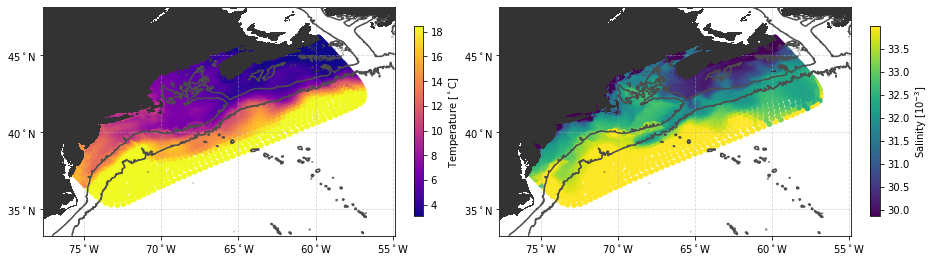

In [38]:
# formatting function for the units
fmt = lambda txt: txt.replace('degrees_','$^\circ$').replace('1e-3','10$^{-3}$')
# key argument function that defines vlim from data quantiles
kw = lambda da,q: {"s":25,"vmin":da.quantile(q[0]).values,"vmax":da.quantile(q[1]).values}

# select the surface layer and the first time output
isel = dict(siglay=0,time=0)

fig,ax = plt.subplots(1,2,figsize=(15,5))

for a in np.ravel(ax):
    a.axis('scaled')
    gebco['elevation'].plot.contour(ax=a,
            levels=[-3000,-200],add_colorbar=False,add_labels=False,colors='0.3',linestyles='solid',zorder=1e3)

    gebco['elevation'].plot.contourf(ax=a,
            levels=[0,1e5],add_colorbar=False,add_labels=False,zorder=1e6+1,extend='neither',colors='0.2')

da = ds.temp.isel(**isel)
C = ax[0].scatter(da.lon,da.lat,c=da,**kw(da,[0.01,0.99]),cmap='plasma')
fig.colorbar(C,ax=ax[0],label=f"{da.long_name.capitalize()} [{fmt(da.units)}]",fraction=0.025)

da = ds.salinity.isel(**isel)
C = ax[1].scatter(da.lon,da.lat,c=da,**kw(da,[0.2,0.99]))
fig.colorbar(C,ax=ax[1],label=f"{da.long_name.capitalize()} [{fmt(da.units)}]",fraction=0.025)

_ = [a.grid(True, ls='--',alpha=0.5) for a in ax]

lablat = lambda lat: f'{lat:.0f}$^\\circ$' if lat==0 else f'{lat:.0f}$^\\circ$N' if lat>0 else f'{-lat:.0f}$^\\circ$S'
lablon = lambda lat: f'{lat:.0f}$^\\circ$' if lat==0 else f'{lat:.0f}$^\\circ$E' if lat>0 else f'{-lat:.0f}$^\\circ$W'

xlim = np.array([gebco.lon.min().values,gebco.lon.max().values])
ylim = np.array([gebco.lat.min().values,gebco.lat.max().values])

xticks = np.arange(*(np.round(xlim/10)*10).astype('int'),5)
yticks = np.arange(*(np.round(ylim/10)*10).astype('int'),5)
for a in np.ravel(ax):
    a.set(
        xticks=xticks,
        yticks=yticks,
        xticklabels=list(map(lablon,xticks)),
        yticklabels=list(map(lablat,yticks)),
        xlabel='',ylabel='',
        xlim=xlim,
        ylim=ylim,
    )

_ = [a.grid(True,linestyle='--',alpha=0.5,zorder=1e7) for a in np.ravel(ax)]

fig.savefig('../img/scatter_temperature_salinity.png',dpi=150,bbox_inches='tight')
